In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, initcap  # Some functions that later will be useful

spark = SparkSession.builder.appName("PySparkETLTelecom").getOrCreate()
path = r'C:\Users\PC\Python Programs\Telecom City Data'

In [2]:
censusDF = spark.read.load(r'C:\Users\PC\Python Programs\Telecom City Data\ISTAT_census_variables_2011.csv'
                           ,format='csv',
                            sep = ',',
                           header='true',
                           inferschema='true').cache()

In [3]:
censusDF.limit(5).toPandas()

c:\users\pc\appdata\local\programs\python\python37-32\lib\site-packages\pyspark\sql\pandas\conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


,PROVINCIA,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,E18,E19,E20,E21,E22,E23,E24,E25,E26,E27
0,Alessandria,427229,204983,222246,158222,198253,11481,44582,14691,85839,...,82121,27855,7197,84634,23155,10813,5564,2523,1896,280402
1,Asti,217573,105370,112203,82119,102538,5404,20767,6745,44773,...,49604,11716,3039,48074,12510,4775,2083,1194,786,134452
2,Biella,182192,86821,95371,69188,82431,5266,18474,6833,37017,...,25523,19595,5795,35030,11310,4776,2066,974,581,112204
3,Cuneo,586378,287786,298592,231452,276983,12473,49417,16053,127243,...,113200,43780,10393,106446,41341,18356,8181,3449,2278,402507
4,Novara,365559,176361,189198,143302,170741,9351,31811,10354,76929,...,40028,25384,5773,39561,22413,10224,4404,2272,1148,199727


In [4]:
censusDF.count()

110

In [5]:
censusDF = censusDF.select('PROVINCIA')

In [6]:
censusDF.createOrReplaceTempView('census')

In [7]:
spark.sql('select * from census').limit(5).show()

+-----------+
|  PROVINCIA|
+-----------+
|Alessandria|
|       Asti|
|     Biella|
|      Cuneo|
|     Novara|
+-----------+



In [8]:
provincesDF = spark.read.load(r"C:\Users\PC\Python Programs\Telecom City Data/Italian_provinces.geojson",
                    format='json',
                    multiline=True,
                    inferSchema='true').cache()

In [9]:
provincesDF.limit(5).toPandas()

,crs,features,type
0,"((urn:ogc:def:crs:EPSG::32632,), name)","[(([[[[460929.5408985989, 5076320.296951921], ...",FeatureCollection


In [10]:
provincesDF.printSchema()

root
 |-- crs: struct (nullable = true)
 |    |-- properties: struct (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |-- type: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- geometry: struct (nullable = true)
 |    |    |    |-- coordinates: array (nullable = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |    |-- type: string (nullable = true)
 |    |    |-- properties: struct (nullable = true)
 |    |    |    |-- PROVINCIA: string (nullable = true)
 |    |    |    |-- SHAPE_AREA: double (nullable = true)
 |    |    |    |-- SIGLA: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- type: string (nullable = true)



In [11]:
provincesDF = provincesDF.select('features.properties.PROVINCIA')

In [12]:
provincesDF = provincesDF.select(explode('PROVINCIA')).withColumnRenamed('col','PROVINCIA')

In [14]:
provincesDF.show(5)

+-----------+
|  PROVINCIA|
+-----------+
|     Novara|
|     Torino|
|   Vercelli|
|      Aosta|
|Alessandria|
+-----------+
only showing top 5 rows



In [15]:
provincesDF.createOrReplaceTempView("provinces")

In [16]:

spark.sql("""select c.PROVINCIA as census, p.PROVINCIA as provinces from
                (select distinct PROVINCIA from census) c 
                    full outer join 
                (select distinct PROVINCIA from provinces) p
                    on c.PROVINCIA = p.PROVINCIA
                where c.PROVINCIA is null or p.PROVINCIA is null
            """).show(truncate=False)

+----------------------------+-------------+
|census                      |provinces    |
+----------------------------+-------------+
|Bolzano/Bozen               |null         |
|null                        |Forli'-Cesena|
|Massa-Carrara               |null         |
|Forlì-Cesena                |null         |
|Valle d'Aosta/Vallée d'Aoste|null         |
|null                        |Bolzano      |
|null                        |Aosta        |
|null                        |Massa Carrara|
+----------------------------+-------------+



In [17]:
censusDF.unpersist()
print(censusDF.is_cached)

# Temporal view
spark.catalog.dropTempView("census")
spark.sql("show tables").show()

False
+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |provinces|       true|
+--------+---------+-----------+



In [21]:
mitoprovincesDF = spark.read.load(path + r"/mi-to-provinces-*.csv",
                    format='csv',
                    sep = ',',
                    header='true',
                    inferSchema='true').cache()

In [22]:
mitoprovincesDF.count()

20047463

In [23]:
mitoprovincesDF.show(5)

+-------------------+------+------------+-------------+-------------+
|           datetime|CellID|provinceName|cell2Province|Province2cell|
+-------------------+------+------------+-------------+-------------+
|2013-11-04 00:00:00|     1|      MILANO|       0.0018|         null|
|2013-11-04 00:00:00|     1|      NAPOLI|         null|       0.0261|
|2013-11-04 00:00:00|     2|      MILANO|       9.0E-4|         null|
|2013-11-04 00:00:00|     2|      NAPOLI|         null|       0.0274|
|2013-11-04 00:00:00|     3|      NAPOLI|         null|       0.0287|
+-------------------+------+------------+-------------+-------------+
only showing top 5 rows



In [24]:
mitoprovincesDF = mitoprovincesDF.withColumn("provinceName", initcap(mitoprovincesDF.provinceName))
mitoprovincesDF.show(3)

+-------------------+------+------------+-------------+-------------+
|           datetime|CellID|provinceName|cell2Province|Province2cell|
+-------------------+------+------------+-------------+-------------+
|2013-11-04 00:00:00|     1|      Milano|       0.0018|         null|
|2013-11-04 00:00:00|     1|      Napoli|         null|       0.0261|
|2013-11-04 00:00:00|     2|      Milano|       9.0E-4|         null|
+-------------------+------+------------+-------------+-------------+
only showing top 3 rows



In [25]:
mitoprovincesDF.createOrReplaceTempView("mitoprovinces")

In [26]:

cdrDF = spark.read.load(path + r"/sms-call-internet-mi-*.csv",
                    format='csv',
                    sep = ',',
                    header='true',
                    inferSchema='true').cache()

In [27]:
cdrDF.show(5)

+-------------------+------+-----------+------+------+------+-------+--------+
|           datetime|CellID|countrycode| smsin|smsout|callin|callout|internet|
+-------------------+------+-----------+------+------+------+-------+--------+
|2013-11-06 00:00:00|     1|          0|0.0814|  null|  null|   null|    null|
|2013-11-06 00:00:00|     1|         39|0.7458|0.7204|0.1626| 0.1057| 52.3219|
|2013-11-06 00:00:00|     2|          0|0.0829|  null|  null|   null|    null|
|2013-11-06 00:00:00|     2|         39|0.7653|0.7409|0.1639| 0.1094| 52.4064|
|2013-11-06 00:00:00|     3|          0|0.0846|  null|  null|   null|    null|
+-------------------+------+-----------+------+------+------+-------+--------+
only showing top 5 rows



In [28]:
cdrDF = cdrDF.na.fill(0)

In [29]:
cdrDF.createOrReplaceTempView("cdr")

In [30]:
spark.sql("show tables").show()

+--------+-------------+-----------+
|database|    tableName|isTemporary|
+--------+-------------+-----------+
|        |          cdr|       true|
|        |mitoprovinces|       true|
|        |    provinces|       true|
+--------+-------------+-----------+



In [31]:
aggcountryDF = spark.sql("""select 
                                CASE countrycode
                                    WHEN 7 THEN "Russia"
                                    WHEN 33 THEN "France"
                                    WHEN 34 THEN "Spain"
                                    WHEN 39 THEN "Italy"
                                    WHEN 44 THEN "United Kingdom"
                                    WHEN 47 THEN "Norway"
                                    WHEN 48 THEN "Poland"
                                    WHEN 49 THEN "Germany"
                                    WHEN 351 THEN "Portugal"
                                    WHEN 420 THEN "Czech Republic"
                                    ELSE "_Others_"
                                END as country,
                                round(sum(smsin),6) smsin, 
                                round(sum(smsout),6) smsout, 
                                round(sum(callin),6) callin, 
                                round(sum(callout),6) callout, 
                                round(sum(internet),6) internet
                            from cdr
                            where countrycode != 0
                            group by country
                            order by 1
                            """)

In [32]:
aggcountryDF.show()

+--------------+---------------+---------------+---------------+---------------+------------------+
|       country|          smsin|         smsout|         callin|        callout|          internet|
+--------------+---------------+---------------+---------------+---------------+------------------+
|Czech Republic|     23707.4905|     13755.0621|      6560.9575|      4612.1064|        27057.8446|
|        France|     134045.724|     89066.3494|     54388.1101|      37023.644|       306821.5801|
|       Germany|     61385.0661|     21897.0994|      25773.665|     20590.2693|        216630.689|
|         Italy|3.07346989943E7|2.46252649659E7|2.95413575959E7|3.28579802243E7|6.85437859768893E8|
|        Norway|       6067.963|      4707.1067|       2238.971|      2320.2161|        14337.4235|
|        Poland|       41015.28|      21470.529|     15806.5298|     10938.0209|        51300.7408|
|      Portugal|       6670.289|      4027.8277|      4272.9558|      3585.9402|        14316.2007|


In [33]:
import matplotlib.pyplot as plt
import numpy as np

In [39]:
plotDF = aggcountryDF.where("country not in ('Italy','_Others_')").toPandas()

<AxesSubplot:ylabel='country'>

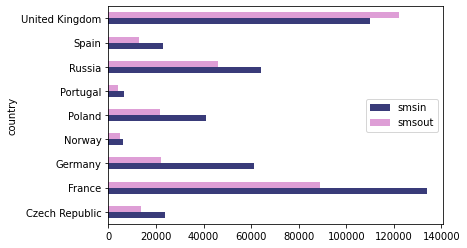

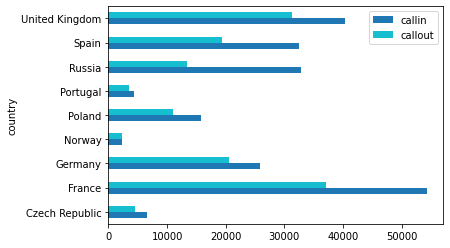

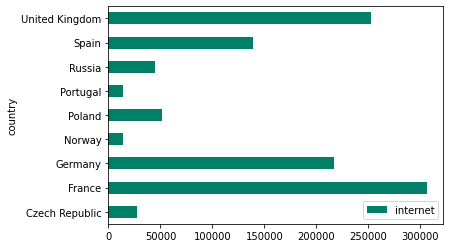

In [40]:
plotDF.plot(kind='barh', x='country', y=['smsin', 'smsout'], colormap='tab20b')
plotDF.plot(kind='barh', x='country', y=['callin', 'callout'], colormap='tab10')
plotDF.plot(kind='barh', x='country', y=['internet'], colormap='summer')